In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.chdir('..')

In [3]:
import pickle
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import configs
from utils import laion_utils as laionu

# Settings

## Image encoder

In [4]:
image_enc_ver = 'clip-vit-base-patch32'
# image_enc_ver = 'vit-base-patch16-224' 
# image_enc_ver = 'beit-base-patch16-224'
# image_enc_ver = 'convnext-base-224-22k-1k'

## Names and paths

In [5]:
# LAION subsets
laion_path = 'laion400m'
laion_until_part = 31

laionet_prefix = 'subset_sm_filt(text_to_name_def_wnid_similarity_clip-vit-base-patch32)'

laionet_file_name = laionet_prefix + '_' + laionu.get_laion_subset_file_name(0, laion_until_part)
laionet_file_path = os.path.join(laion_path, laionet_file_name)

print(laionet_file_path)

# ILSVRC
ilsvrc_path = 'ilsvrc2012'

ival_prefix = 'ILSVRC2012_val'

ival_file_name = ival_prefix + '.parquet'
ival_file_path = os.path.join(ilsvrc_path, ival_file_name)

print('\n')
print(ival_file_path)

# General
prefixes = [laionet_prefix, ival_prefix]
tags = ['LAIONet', 'ImageNet']

# Labels (maps)
laionet_labels_path = os.path.join(laion_path, 'processed', 'ilsvrc_labels')
laionet_labels_filter = f'wnid2laionindices({laionet_prefix}).pkl'

# Intra-class similarities
img_img_sims_path = os.path.join('laion400m', 'processed', 'clip_image_similarities')

postfix = f'({image_enc_ver})' if image_enc_ver != configs.CLIPConfig.DEFAULT_VERSION else ''
prefix_wnid_to_img_img_sim_file_name = lambda p, w: p + f'_img_img_sims({w}){postfix}.pkl'

laion400m/subset_sm_filt(text_to_name_def_wnid_similarity_clip-vit-base-patch32)_part-00000-to-part00031-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet


ilsvrc2012/ILSVRC2012_val.parquet


# Load

## Load maps

In [6]:
with open(os.path.join(laionet_labels_path, laionet_labels_filter), 'rb') as f:
    wnid2laionindices = pickle.load(f)

# Drop empty indices
wnid2laionindices = {wnid: indices for wnid, indices in wnid2laionindices.items() if len(indices) > 0}

## Load intra-class similarities

In [7]:
def vec(x):
    msk = np.tril(np.eye(len(x)) < 0.5)
    return x[msk]

In [8]:
prefix2wnid2sims = {p: {} for p in prefixes}

for prefix in prefixes:
    for wnid in wnid2laionindices:
        pw_sim_path = os.path.join(img_img_sims_path, prefix_wnid_to_img_img_sim_file_name(prefix, wnid))

        if not os.path.exists(pw_sim_path):
            continue

        with open(pw_sim_path, 'rb') as f:
            pw_sim_dict = pickle.load(f)

        pw_sim = pw_sim_dict['similarities']

        prefix2wnid2sims[prefix][wnid] = vec(pw_sim)
    
    print(prefix, len(prefix2wnid2sims[prefix]))

subset_sm_filt(text_to_name_def_wnid_similarity_clip-vit-base-patch32) 896
ILSVRC2012_val 915


# Process

## Find common WNIDs

In [9]:
common_wnids = set(prefix2wnid2sims[prefixes[0]].keys())

for prefix in prefixes[1:]:
    common_wnids.intersection_update(prefix2wnid2sims[prefix].keys())
    
print(len(common_wnids))

896


## Resample similarities for each common WNID

In [10]:
prefix2sims = {p: [] for p in prefixes}

for prefix in tqdm(prefixes):
    for wnid in common_wnids:
        sims = prefix2wnid2sims[prefix][wnid]
    
        n_sample = np.min([len(sims), 100])
        
        prefix2sims[prefix].extend(np.random.choice(sims, size=(n_sample,), replace=True))

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 32.71it/s]


# Plot distributions

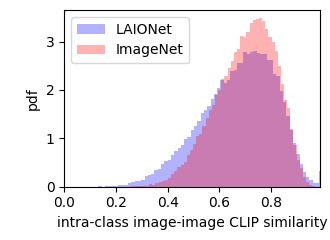

In [11]:
plt.figure(figsize=(3.4, 2.5))

cl = lambda i_p: [(i_p == 1)*1, (i_p == 2)*1, (i_p == 0)*1]

for i_p, prefix in enumerate(prefixes):
    _ = plt.hist(prefix2sims[prefix], bins=70, color=cl(i_p), alpha=0.3, density=True)

plt.legend(tags)

plt.xlabel('intra-class image-image CLIP similarity')
plt.ylabel('\npdf')

plt.xlim([0, 0.99])

plt.tight_layout()

plt.savefig(os.path.join(
    'figs', 
    f'{"_".join(prefixes)}_intra-class_img_img_sims{postfix}_resampled.pdf'
), bbox_inches='tight')

# Test per WNID

In [12]:
prefix2avgsims = {p: [] for p in prefixes}
prefix2errsims = {p: [] for p in prefixes}

for wnid in common_wnids:
    is_valid = True
    for prefix in prefixes:
        if len(prefix2wnid2sims[prefix][wnid]) < 7:
            is_valid = False
    if not is_valid:
        continue
    
    for prefix in prefixes:
        pw_sim = prefix2wnid2sims[prefix][wnid]
        
        prefix2avgsims[prefix].append(np.mean(pw_sim))
        prefix2errsims[prefix].append(1.96*np.std(pw_sim)/np.sqrt(len(pw_sim) - 1))

for prefix in prefixes:
    prefix2avgsims[prefix] = np.array(prefix2avgsims[prefix])
    prefix2errsims[prefix] = np.array(prefix2errsims[prefix])

avg < 0: 0.6639908256880734
UCB < 0: 502 out of 872 (0.5756880733944955)
LCB > 0: 243 out of 872 (0.2786697247706422)


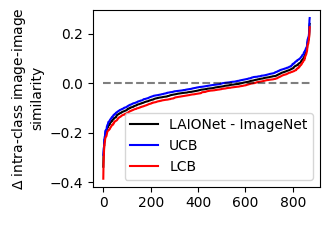

In [13]:
plt.figure(figsize=(3.4, 2.5))

assert len(prefixes) == 2

p1, p2 = prefixes

diff_avg_sims = prefix2avgsims[p1] - prefix2avgsims[p2]
diff_err_sims = np.sqrt(prefix2errsims[p1]**2 + prefix2errsims[p2]**2)

sorted_locs = np.argsort(diff_avg_sims)

ucb_sims = np.sort(diff_avg_sims + diff_err_sims)
lcb_sims = np.sort(diff_avg_sims - diff_err_sims)

x = range(len(sorted_locs))

plt.plot(x, diff_avg_sims[sorted_locs], color='k')
plt.plot(x, ucb_sims, 'b')
plt.plot(x, lcb_sims, 'r')

plt.plot(x, [0]*len(x), 'k--', alpha=0.5)

plt.legend([f'{tags[0]} - {tags[1]}', 'UCB', 'LCB'])

plt.xlabel(' ')
plt.ylabel(r'$\Delta$ intra-class image-image' + '\n' + 'similarity')

plt.tight_layout()

plt.savefig(os.path.join('figs', f'{p1}_{p2}_intra-class_img_img_sims{postfix}_diff.pdf'), bbox_inches='tight')

print(f'avg < 0: {np.mean(diff_avg_sims < 0)}')
print(f'UCB < 0: {np.sum(ucb_sims < 0)} out of {len(ucb_sims)} ({np.mean(ucb_sims < 0)})')
print(f'LCB > 0: {np.sum(lcb_sims > 0)} out of {len(lcb_sims)} ({np.mean(lcb_sims > 0)})')

# Plot per WNID test results for all encoders 

After running the above for all image encoders, we recorded these numbers:

In [14]:
enc2ucb = {
    'CLIP': 0.5756,
    'ViT': 0.5995,
    'ConvNeXt': 0.6997,
    'BEiT': 0.6674,
}

enc2lcb = {
    'CLIP': 0.2786,
    'ViT': 0.2991,
    'ConvNeXt': 0.1963,
    'BEiT': 0.2289,
}

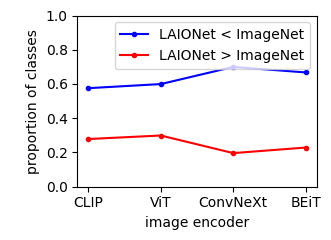

In [15]:
plt.figure(figsize=(3.4, 2.5))

ucbs = [v for _, v in enc2ucb.items()]
lcbs = [v for _, v in enc2lcb.items()]

plt.plot(range(len(enc2ucb)), ucbs, 'b', marker='.')

plt.plot(range(len(enc2lcb)), lcbs, 'r', marker='.')

plt.xticks(range(len(enc2ucb)), enc2ucb.keys())

plt.xlabel('image encoder')
plt.ylabel('\nproportion of classes')

plt.legend([f'{tags[0]} < {tags[1]}', f'{tags[0]} > {tags[1]}'])

plt.ylim([0, 1])

plt.tight_layout()

plt.savefig(os.path.join('figs', f'{p1}_{p2}_prop_lower_sim.pdf'), bbox_inches='tight')